# Perceval Quest
#### Author: *Valentin Deumier*

Our goal is to start by creating a 'classical' neural network and train it on the famous MNIST handwritten digits dataset, and then try to upgrade it by using Linear Optical Quantum Computing, in hope to increase the accuracy of the model and lower the duration of the calculations.

### <u>2: A hybrid model</u>

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os
os.environ["OMP_NUM_THREADS"] = "12"
print(np.__version__)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import perceval as pcvl
import perceval.components as comp
from perceval.rendering.circuit import SymbSkin, PhysSkin
from perceval import Circuit
from perceval import catalog

# Parameters
IMG_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

1.24.3


2025-01-14 09:15:35.352424: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 09:15:35.395081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 09:15:36.085861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/deumier/Documents/LOQC_MNIST/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
# Data into numpy arrays
def load_data(filename):

    data = pd.read_csv(filename)
    X = np.array(data['image'].str.split(',', expand=True).values)

    # Remove the [ ] from the image data (fastest method I found)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] = X[i, j].replace('[', '').replace(']', '')
    X = X.astype(float)

    y = data['label'].values

    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)/255.0      # Reshape and normalize
    y = to_categorical(y, NUM_CLASSES)
    return X, y

# Get the absolute path to the data folder
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, 'data')

# Load the data
train_file = os.path.join(data_dir, 'train.csv')
X_train, y_train = load_data(train_file)
val_file = os.path.join(data_dir, 'val.csv')
X_val, y_val = load_data(val_file)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Divide the image resolution by 4 using max pooling and avg pooling
X_train = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_train))/255.0
X_val = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_val))/255.0

X_train = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_train))
X_val = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_val))

# This step is necessary as the number of modes needed for the circuit is IMG_SIZE, 
# and I found that seven modes is a maximum that I can do before the calculation takes too long
# It could be improved with better computing ressources

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6000, 28, 28, 1) (6000, 10) (600, 28, 28, 1) (600, 10)
(6000, 7, 7, 1) (6000, 10) (600, 7, 7, 1) (600, 10)


2025-01-14 09:15:40.513873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31044 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:d5:00.0, compute capability: 7.0
2025-01-14 09:15:40.831794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


The idea here is to encode the image data into quantum data while preserving the 2-dimensional structure of the image. \
\
Like in the CNN model, we want neighbours pixels to remain close to each other in the quantum representation so that we can perform "local" transformation (the equivalent of convoluting the image with a kernel), so the representation has to be continuous along both axis.\
This means that we can't flatten the data, so we can't use basis, angle or amplitude embedding.\
\
An idea could be to encode the image in a matrix representation of a unitary transformation (that could also be parametrized, and have its parameters be optimized).\
\
Being inspired by the solution of Schrodinger's equation for a time-independant Hamiltonian, we are going to represent the image $\mathbf{x}$ as the resulting evolution operator :

$$ U_t(\mathbf{x}) = \exp(-iH_{\mathbf{x}}t) $$

Where $H_{\mathbf{x}}$ is the symetric part of our image matrix (so that $U_t(\mathbf{x})$ is unitary):

$$ H_{\mathbf{x}} = \frac{\mathbf{x} + \mathbf{x}^T}{2} $$

with $t \in \mathbb{R}$ a parameter that we can tweak.

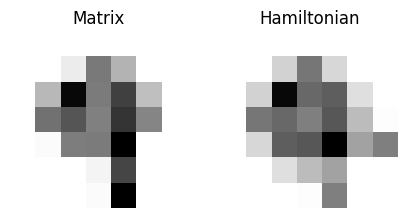

In [4]:
def toHamiltonian(x):
    H = 0.5*(x[:, :, 0] + x[:, :, 0].T)
    return H

def plot_hamiltonian(x):
    L = [x, toHamiltonian(x)]
    labels = ['Matrix', 'Hamiltonian']
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i in range(2):
        axes[i].imshow(L[i], cmap='gray_r')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Plot the first image and its Hamiltonian
plot_hamiltonian(X_train[1])

In [5]:
# As an example, we are computing the operator associated with the second image

def U(x: np.ndarray, t: float) -> np.ndarray:
    """Compute the unitary operator associated with the Hamiltonian x and time t"""
    H = toHamiltonian(x)
    return linalg.expm(-1j*H*t)

# M = pcvl.Matrix(U(X_train[1], 1000))
# c1 = comp.Unitary(U=M)

# Decompose the unitary into a circuit
# ub = pcvl.Circuit(2, name="ub") // comp.BS() // (0, comp.PS(phi=pcvl.Parameter("φ_a"))) // comp.BS() // (1, comp.PS(phi=pcvl.Parameter("φ_b")))
# c2 = pcvl.Circuit.decomposition(M, ub, shape=pcvl.InterferometerShape.TRIANGLE)
# pcvl.pdisplay(c2)

To reproduce the local effect of the convolution, the next layer will be constituted of a brickwork layout of 2 modes circuits that are acting on modes close to each other.\
\
The operator associated with this layer will be denoted $V(\mathbf{\omega})$, with $\mathbf{\omega}$ being the array of parameters of the 2 modes circuits.\
\
In some papers, we can read that this can be done with SU(N) gates. This is a more optimized approach that could be interesting to try in future upgrades, mainly, we have explicit formulas for the gradient of SU(N) gates that could improve the training time.

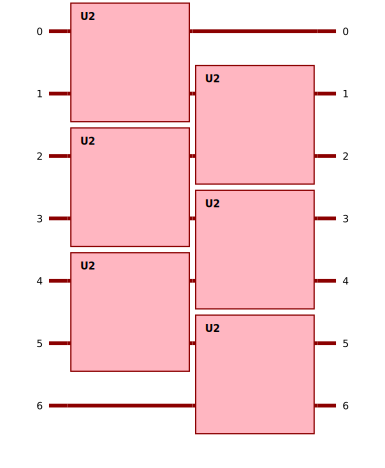

In [6]:
def brickwork(
    omega: np.ndarray,
    num_modes: int,
) -> Circuit:
    """
    Create a brickwork circuit with generic 2 modes circuits.
    Args:   
        omega         : generic 2 modes circuits parameters (shape: [num_modes - 1, 4])
        num_modes : Width of circuit
    Returns:
        Circuit
    """
    circ = Circuit(num_modes)
    even_modes = np.arange(0, num_modes - 1, 2)
    odd_modes = np.arange(1, num_modes - 1, 2)

    for k in even_modes:
        params = omega[int(k)]
        circ.add(int(k), catalog["generic 2 mode circuit"].build_circuit(theta=params[0], phi_tl=params[1], phi_bl=params[2], phi_tr=params[3]))
    for j in odd_modes:
        params = omega[int(j)]
        circ.add(int(j), catalog["generic 2 mode circuit"].build_circuit(theta=params[0], phi_tl=params[1], phi_bl=params[2], phi_tr=params[3]))

    return circ

# Example of a V(omega) layer
omega = np.zeros((6, 4))
c2 = brickwork(omega, 7)
pcvl.pdisplay(c2)

In [7]:
N = 7      # Number of photons
m = 7      # Number of modes   
L = 5       # Number of layers

# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

# Random parameters for the circuit initialization
t_params = np.random.uniform(0, 100, L)
omega_params = np.random.uniform(0, 2*np.pi, (L*(m-1), 4))
print(omega_params.shape)

|1,1,1,1,1,1,1>
(30, 4)


The code will follow the following scheme:
- Use the fonction **create_circuit(x, params)** that create the circuit with L layers $U_t(\mathbf{x}) V(\mathbf{\omega})$ associated to the image $\mathbf{x}$.
- Compute the full output probability with the input $N*|1>$.
- Convert the output into a predicted label
- Compute the sparse categorical cross-entropy loss (that is a function of $\mathbf{x}$ and the parameters)
- Do a minimization step.

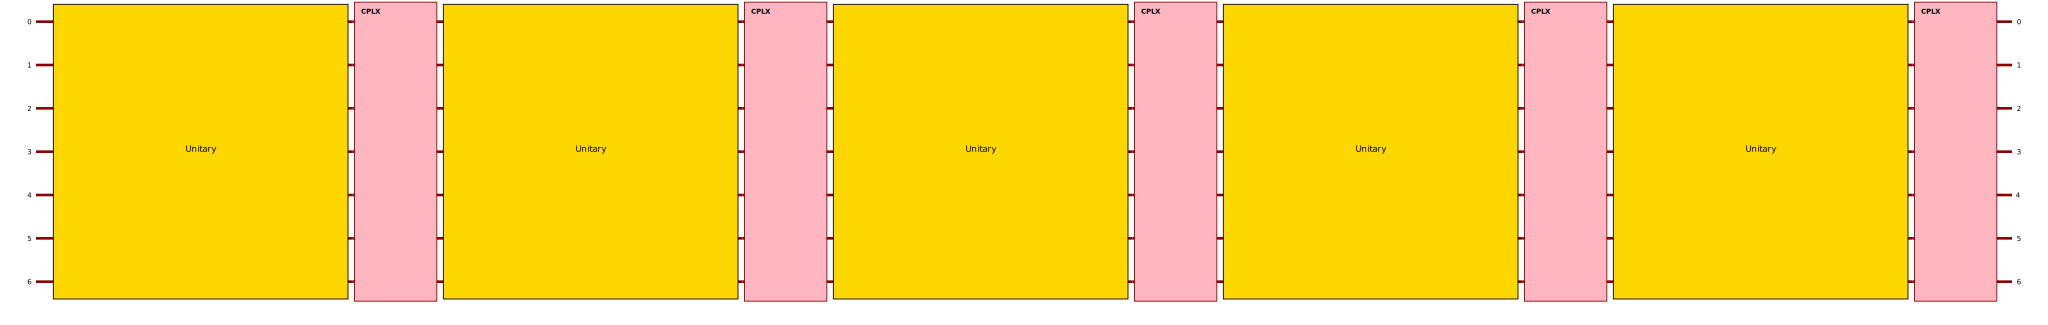

In [8]:
def create_circuit(x, t_params, omega_params):
    c = Circuit(m)
    for i in range(L):
        c.add(0, comp.Unitary(U=pcvl.Matrix(U(x, t_params[i]))))
        c.add(0, brickwork(omega_params[i*(m-1):(i+1)*(m-1)], m))
    return c

c = create_circuit(X_train[1], t_params, omega_params)
pcvl.pdisplay(c)

In [9]:
def compute_probabilities(x, t_params, omega_params):
    processor = pcvl.Processor("SLOS", create_circuit(x, t_params, omega_params))
    processor.with_input(input_state)
    sampler = pcvl.algorithm.Sampler(processor)
    prob_dist = sampler.probs()
    return prob_dist

# processor = pcvl.Processor("SLOS", create_circuit(X_train[2], t_params, omega_params))
# processor.with_input(input_state)

# sampler = pcvl.algorithm.Sampler(processor)
# prob_dist = sampler.probs()

# argmax = np.argmax(list(prob_dist['results'].values()))
# most_probable_output = list(prob_dist['results'].keys())[argmax]
# most_probable_probability = list(prob_dist['results'].values())[argmax]

# print("The most probable output is", most_probable_output, "with probability", most_probable_probability)

To convert the output state of the circuit into a predicted label, my intuition is to think of the output state as a spatial distribution of guesses:
* The more there are photons close to the top mode, the more the predicted label is close to 0
* The more there are photons close to the bottom mode, the more the predicted label is close to 9

I have decided to take the exponential of this spatial distribution, so that the output is less biased towards middle values like 4 or 5.

In [10]:
# Convert from the repartition of photon in the most probable output to a label
def output_to_label(output):
    return int(np.round(np.average(range(len(output)), weights=np.exp(output))*3/2))       # Scale the output to the range [0, 9]

def confidence_array(prob_dist):
    confidence = np.zeros(NUM_CLASSES)
    for output, prob in prob_dist['results'].items():
        label = output_to_label(output)
        confidence[label] += prob
    return confidence

# print(output_to_label(most_probable_output))

In [11]:
def sparse_categorical_crossentropy(y_true, y_pred):
    return -np.log(y_pred[y_true])

def sparse_categorical_accuracy(y_true, y_pred):
    return np.argmax(y_pred) == y_true

def model_accuracy(X, y, t_params, omega_params):
    accuracy = 0
    for i in range(X.shape[0]):
        prob_dist = compute_probabilities(X[i], t_params, omega_params)
        confidence = confidence_array(prob_dist)
        y_pred = np.argmax(confidence)
        y_true = np.argmax(y[i])
        accuracy += sparse_categorical_accuracy(y_true, confidence)
    return accuracy/X.shape[0]


In [12]:
def minimize_step(batch_x, batch_y, t_params, omega_params, learning_rate_o=0.03, learning_rate_t=0.1):
    avg_gradient_t = np.zeros_like(t_params)
    avg_gradient_o = np.zeros_like(omega_params)
    avg_loss = 0

    for x, y_true in zip(batch_x, batch_y):

        # Compute the probabilities
        prob_dist = compute_probabilities(x, t_params, omega_params)
        y_pred = confidence_array(prob_dist)
    
        # Compute the loss
        loss = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        avg_loss += loss
    
        # Compute the gradients (numerical gradient approximation)
        grad_t_params = np.zeros_like(t_params)
        grad_omega_params = np.zeros_like(omega_params)
    
        epsilon = 0.01
        for i in range(len(t_params)):
            t_params[i] += epsilon
            prob_dist = compute_probabilities(x, t_params, omega_params)
            y_pred = confidence_array(prob_dist)
            loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
            grad_t_params[i] = (loss_plus - loss) / epsilon
            t_params[i] -= epsilon
    
        for i in range(len(omega_params)):
            omega_params[i] += epsilon
            prob_dist = compute_probabilities(x, t_params, omega_params)
            y_pred = confidence_array(prob_dist)
            loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
            grad_omega_params[i] = (loss_plus - loss) / epsilon
            omega_params[i] -= epsilon
    
        avg_gradient_t += grad_t_params
        avg_gradient_o += grad_omega_params

    avg_loss /= len(batch_x)
    avg_gradient_t /= len(batch_x)
    avg_gradient_o /= len(batch_x)

    # Update the parameters
    t_params -= learning_rate_t * avg_gradient_t
    omega_params -= learning_rate_o * avg_gradient_o
    # print(np.max(grad_t_params), np.max(grad_omega_params))
    
    return t_params, omega_params, avg_loss

# Example usage
batch_x = X_train[0: BATCH_SIZE]
batch_y = y_train[0: BATCH_SIZE]
t_params, omega_params, loss = minimize_step(batch_x, batch_y, t_params, omega_params)
print("Updated t_params:", t_params)
print("Updated omega_params:", omega_params)
print("Batch loss:", loss)

KeyboardInterrupt: 

In [ ]:
# Training loop

def train(X_train, y_train, X_val, y_val, t_params, omega_params, learning_rate_t=0.1, learning_rate_o=0.03, epochs=1):
    loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        print("Epoch", epoch)
        shuffled_indices = np.random.permutation(len(X_train))
        for batch in tqdm(range(0, len(X_train), BATCH_SIZE), desc="Training"):
            batch_indices = shuffled_indices[batch: min(batch + BATCH_SIZE, len(X_train))]
            x = X_train[batch_indices]
            y_true = y_train[batch_indices]
            t_params, omega_params, loss = minimize_step(x, y_true, t_params, omega_params, learning_rate_t, learning_rate_o)
            print("Loss:", loss)
            loss_history.append(loss)
        val_acc = model_accuracy(X_val, y_val, t_params, omega_params)
        val_acc_history.append(val_acc)
        print("Validation accuracy:", val_acc)
    return t_params, omega_params, loss_history, val_acc_history

t_params, omega_params, loss_history, val_acc_history = train(X_train, y_train, X_val, y_val, t_params, omega_params, epochs=1)
# In my case, using 10 cores, the training takes about 6 hour for one epoch

# Save the parameters

# Ensure the directory exists
modelparams_dir = os.path.join(script_dir, 'modelparams')
os.makedirs(modelparams_dir, exist_ok=True)

# Save the parameters
np.save(os.path.join(modelparams_dir, 't_params.npy'), t_params)
np.save(os.path.join(modelparams_dir, 'omega_params.npy'), omega_params)
np.save(os.path.join(modelparams_dir, 'loss_history.npy'), loss_history)
np.save(os.path.join(modelparams_dir, 'val_acc_history.npy'), val_acc_history)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel("Number of batches")
plt.ylabel("Loss")
plt.title("Loss history")
plt.grid()

plt.savefig(os.path.join(modelparams_dir, "loss_history.png"))
plt.show()

Epoch 0


Training:   1%|          | 1/94 [03:53<6:02:27, 233.84s/it]

Loss: 2.632051876633024


Training:   2%|▏         | 2/94 [07:49<6:00:15, 234.95s/it]

Loss: 2.6742644019628634


Training:   3%|▎         | 3/94 [11:45<5:56:54, 235.33s/it]

Loss: 2.6506725528230533


Training:   4%|▍         | 4/94 [15:40<5:53:08, 235.43s/it]

Loss: 2.6871506572420065


Training:   5%|▌         | 5/94 [19:37<5:49:35, 235.69s/it]

Loss: 2.6648098684809134


Training:   6%|▋         | 6/94 [23:32<5:45:42, 235.70s/it]

Loss: 2.916231436185227


Training:   7%|▋         | 7/94 [27:40<5:47:18, 239.53s/it]

Loss: 2.797246775863258


Training:   9%|▊         | 8/94 [31:36<5:41:54, 238.54s/it]

Loss: 2.600902094658121


Training:  10%|▉         | 9/94 [35:29<5:35:32, 236.86s/it]

Loss: 2.5298831950242553


Training:  11%|█         | 10/94 [39:29<5:33:01, 237.88s/it]

Loss: 2.5333925233489962


Training:  12%|█▏        | 11/94 [43:21<5:26:28, 236.00s/it]

Loss: 2.7953316996887323


Training:  13%|█▎        | 12/94 [47:24<5:25:14, 237.99s/it]

Loss: 2.8462777011761635


Training:  14%|█▍        | 13/94 [51:30<5:24:36, 240.45s/it]

Loss: 2.449176736265692


Training:  15%|█▍        | 14/94 [55:59<5:32:03, 249.05s/it]

Loss: 2.423853621694894


Training:  16%|█▌        | 15/94 [1:00:14<5:30:30, 251.02s/it]

Loss: 2.5929939229493457


Training:  17%|█▋        | 16/94 [1:04:08<5:19:40, 245.90s/it]

Loss: 2.625094310171455


Training:  18%|█▊        | 17/94 [1:08:00<5:10:12, 241.71s/it]

Loss: 2.635295779530891


Training:  19%|█▉        | 18/94 [1:11:52<5:02:19, 238.68s/it]

Loss: 2.565975088393935


Training:  20%|██        | 19/94 [1:15:44<4:55:46, 236.62s/it]

Loss: 2.744309563283925


Training:  21%|██▏       | 20/94 [1:19:35<4:50:00, 235.14s/it]

Loss: 2.84534052367436


Training:  22%|██▏       | 21/94 [1:23:27<4:44:47, 234.08s/it]

Loss: 2.5294047201733076


Training:  23%|██▎       | 22/94 [1:27:20<4:40:24, 233.67s/it]

Loss: 2.669247110094025


Training:  24%|██▍       | 23/94 [1:31:34<4:43:56, 239.95s/it]

Loss: 2.7612908757162535


Training:  26%|██▌       | 24/94 [1:35:21<4:35:06, 235.81s/it]

Loss: 2.763971304709317


Training:  27%|██▋       | 25/94 [1:39:08<4:28:16, 233.29s/it]

Loss: 2.6189962830540625


Training:  28%|██▊       | 26/94 [1:42:55<4:22:24, 231.54s/it]

Loss: 2.6820200974489588


Training:  29%|██▊       | 27/94 [1:46:43<4:17:14, 230.37s/it]

Loss: 2.5406069630360273


Training:  30%|██▉       | 28/94 [1:50:30<4:12:15, 229.32s/it]

Loss: 2.7874349931053084


Training:  31%|███       | 29/94 [1:54:17<4:07:46, 228.71s/it]

Loss: 2.495371459978209


Training:  32%|███▏      | 30/94 [1:58:05<4:03:30, 228.29s/it]

Loss: 2.67421972243449


Training:  33%|███▎      | 31/94 [2:01:52<3:59:29, 228.09s/it]

Loss: 2.668715908759765


Training:  34%|███▍      | 32/94 [2:05:40<3:55:33, 227.96s/it]

Loss: 2.7282098327779054


Training:  35%|███▌      | 33/94 [2:09:27<3:51:29, 227.69s/it]

Loss: 2.559604057418414


Training:  36%|███▌      | 34/94 [2:13:14<3:47:30, 227.51s/it]

Loss: 2.6759582294185784


Training:  37%|███▋      | 35/94 [2:17:02<3:43:44, 227.53s/it]

Loss: 2.5020620199342987


Training:  38%|███▊      | 36/94 [2:20:49<3:40:01, 227.61s/it]

Loss: 2.7237663079563768


Training:  39%|███▉      | 37/94 [2:24:37<3:36:07, 227.50s/it]

Loss: 2.7951191240284743


Training:  40%|████      | 38/94 [2:28:24<3:32:13, 227.39s/it]

Loss: 2.7110741323424703


Training:  41%|████▏     | 39/94 [2:32:10<3:28:16, 227.21s/it]

Loss: 2.7386280091018813


Training:  43%|████▎     | 40/94 [2:35:57<3:24:23, 227.11s/it]

Loss: 2.6029305342439013


Training:  44%|████▎     | 41/94 [2:39:45<3:20:38, 227.14s/it]

Loss: 2.74579022384937


Training:  45%|████▍     | 42/94 [2:43:32<3:16:52, 227.16s/it]

Loss: 2.660585187584163


Training:  46%|████▌     | 43/94 [2:47:20<3:13:14, 227.34s/it]

Loss: 2.509370233980635


Training:  47%|████▋     | 44/94 [2:51:06<3:09:19, 227.20s/it]

Loss: 2.624282269456398


Training:  48%|████▊     | 45/94 [2:54:53<3:05:27, 227.10s/it]

Loss: 2.6808480573432285


Training:  49%|████▉     | 46/94 [2:58:40<3:01:41, 227.12s/it]

Loss: 2.4970621657256857


Training:  50%|█████     | 47/94 [3:02:28<2:57:57, 227.18s/it]

Loss: 2.666701898337686


Training:  51%|█████     | 48/94 [3:06:15<2:54:12, 227.22s/it]

Loss: 2.739100765985712


Training:  52%|█████▏    | 49/94 [3:10:03<2:50:30, 227.35s/it]

Loss: 2.5789710597756677


Training:  53%|█████▎    | 50/94 [3:13:50<2:46:43, 227.35s/it]

Loss: 2.6431997314358084


In [14]:
modelparams_dir = os.path.join(script_dir, 'modelparams')
os.makedirs(modelparams_dir, exist_ok=True)

In [16]:
# Load the parameters

t_params = np.load(os.path.join(modelparams_dir, 't_params.npy'))
omega_params = np.load(os.path.join(modelparams_dir, 'omega_params.npy'))
loss_history = np.load(os.path.join(modelparams_dir, 'loss_history.npy'))
val_acc_history = np.load(os.path.join(modelparams_dir, 'val_acc_history.npy'))

print("Validarion accuracy:", val_acc_history[-1])

# Evaluate the model

# print("Training accuracy:", model_accuracy(X_train, y_train, t_params, omega_params))
# print("Validation accuracy:", model_accuracy(X_val, y_val, t_params, omega_params))

Validarion accuracy: 0.10666666666666667
